### 0. 패키지 로딩하기

In [1]:
from albumentations              import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers     import *
from tensorflow.keras.models     import *
from skimage.transform           import resize
from skimage.io                  import imread
from PIL                         import Image
from glob                        import glob

import matplotlib.pyplot as plt
import tensorflow        as tf
import numpy             as np
import math
import os

### 1. 데이터 로더(data loader) 만들기

* 이미지와 데이터셋이 주어졌으니 모델을 학습시킬 수 있는 데이터 로더(data loader)를 만들어보자.
* 로더는 입력값 (224, 224), 출력값 (224, 244) 크기를 갖는 모델을 학습시킬 수 있도록 데이터셋을 파싱해야 한다.
* 이때 데이터 로더에 augmentation을 적용해보자.
* 오늘은 파이썬에서 많이 사용되는 albumentations을 사용해 보겠다.
* 하지만 Augmentation의 경우 imgaug 등 다른 라이브러리를 활용해도 된다.
* 또한 학습셋의 일정량을 검증 데이터셋(validation dataset)으로 활용할 수 있도록 해야한다.
* 만든 후에는 직접 데이터셋이 잘 파싱되어 나오는지 꼭 확인해보자.
* 데이터셋에 오류가 없어야 성능이 안 나오더라도 문제를 찾아내기 쉽다.

#### 1_1. Albumentation 의 사용법을 간단히 알아보기

* 아래는 Albumentation에서 다양한 augmentation 기법을 확률적으로 적용할 수 있게 해주는 Compose()의 활용예이다.
* imgaug의 Sometimes()와 유사한 기능이다.

In [2]:
def build_augmentation(is_train = True):
    if is_train:                        # 훈련용 데이터일 경우
        return Compose([
            HorizontalFlip(p = 0.5),    # 50%의 확률로 좌우대칭
            RandomSizedCrop(            # 50%의 확률로 RandomSizedCrop
            min_max_height = (300, 370),
            w2h_ratio      = 370 / 1242,
            height         = 224,
            width          = 224,
            p              = 0.5
            ),
            Resize(                     # 입력이미지를 224X224로 resize
                width  = 224,
                height = 224
            )
        ])
    return Compose([                    # 테스트용 데이터일 경우에는 224X224로 resize만 수행한다. 
        Resize(
            width  = 224,
            height = 224
        )
    ])

In [3]:
dir_path = os.getenv("HOME") + "/aiffel/semantic_segmentation/data/training"
dir_path

'/home/aiffel-dj52/aiffel/semantic_segmentation/data/training'

In [4]:
augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

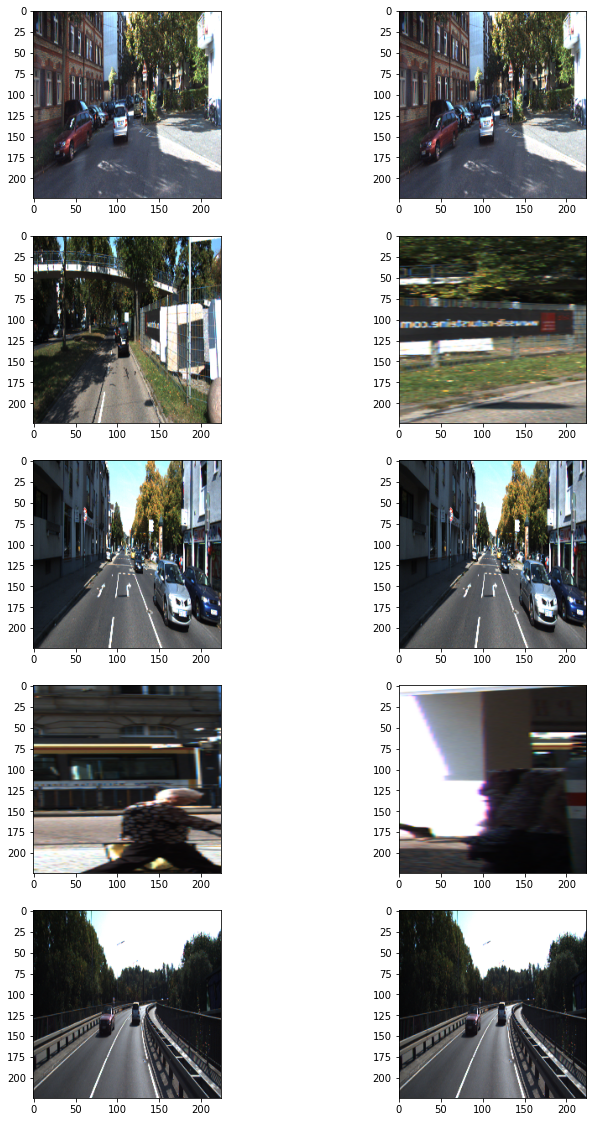

In [5]:
# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 보자.  
plt.figure(figsize = (12, 20))

for i in range(5):
    image      = imread(input_images[i]) 
    image_data = {"image" : image}
    resized    = augmentation(**image_data, is_train = False)
    processed  = augmentation(**image_data)
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(resized["image"])    # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
    
plt.show()

* 이제 데이터셋을 구성해 보자.
* 이번에는 tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터를 구성해 본다.

In [6]:
class KittiGenerator(tf.keras.utils.Sequence):
    """
    KittiGenerator는 tf.keras.utils.Sequence를 상속받는다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용한다.
    """
    def __init__(self, 
                 dir_path,
                 batch_size   = 16,
                 img_size     = (224, 224, 3),
                 output_size  = (224, 224),
                 is_train     = True,
                 augmentation = None):
        """
        dir_path     : dataset의 directory path이다.
        batch_size   : batch_size이다.
        img_size     : preprocess에 사용할 입력이미지의 크기이다.
        output_size  : ground_truth를 만들어주기 위한 크기이다.
        is_train     : 이 Generator가 학습용인지 테스트용인지 구분한다.
        augmentation : 적용하길 원하는 augmentation 함수를 인자로 받는다.
        """
        self.dir_path     = dir_path
        self.batch_size   = batch_size
        self.is_train     = is_train
        self.dir_path     = dir_path
        self.augmentation = augmentation
        self.img_size     = img_size
        self.output_size  = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인한다.
        self.data = self.load_dataset()
    
    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수이다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야한다.
        input_images = glob(os.path.join(self.dir_path, "image_2",  "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        
        data = [_ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환한다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만든다.
        # 입력은 resize 및 augmentation이 적용된 input image이고 
        # 출력은 semantic label이다.
        batch_data = self.data[
            index * self.batch_size:
            (index + 1) * self.batch_size
        ]
        inputs  = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input                      = imread(input_img_path)
            _output                     = imread(output_path)
            _output                     = (_output == 7).astype(np.uint8) * 1
            
            data = {
                "image": _input,
                "mask": _output
            }
            
            augmented  = self.augmentation(**data)
            inputs[i]  = augmented["image"] / 255
            outputs[i] = augmented["mask"]
            
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수이다.
        # 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
        return self.indexes

In [7]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train = False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation = augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation = test_preproc,
    is_train     = False
)

In [8]:
train_generator

In [9]:
test_generator

### 2. 시맨틱 세그멘테이션 모델

#### 2_1. 모델 구조 만들기

* 시맨틱 세그멘테이션을 위한 모델을 만든다.
* 세그멘테이션 모델 중 구조상 비교적 구현이 단순한 U-Net을 구현한다.
* 이때 입력 이미지의 크기는 위에서 만든 데이터셋에 맞춰서 만들어야 한다.
* 사용에 필요한 레이어와 연산은 다음과 같다. 그리고 필요에 따라서 Dropout등의 다른 레이어를 적용해보자.
* Conv2D, UpSampling2D, MaxPooling2D, concatenate

In [10]:
def build_unet_model(input_shape = (224, 224, 3)):
    inputs = Input(input_shape)
    
    # Contracting Path
    conv1 = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(inputs)
    conv1 = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv1)
    pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool1)
    conv2 = Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv2)
    pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool2)
    conv3 = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv3)
    pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool3)
    conv4 = Conv2D(512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size = (2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool4)  
    conv5 = Conv2D(1024, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv5)

    # Expanding Path
    drop5 = Dropout(0.5)(conv5)
    
    up6    = Conv2D(512, 2, activation = "relu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2, 2))(drop5)) 
    merge6 = concatenate([drop4, up6], axis = 3)
    conv6  = Conv2D(512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge6)
    conv6  = Conv2D(512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv6)
    
    up7    = Conv2D(256, 2, activation = "relu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis = 3)
    conv7  = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge7)
    conv7  = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv7)
    
    up8    = Conv2D(128, 2, activation = "relu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis = 3)
    conv8  = Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge8)
    conv8  = Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv8)
    
    up9    = Conv2D(64, 2, activation = "relu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis = 3)
    conv9  = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge9)
    conv9  = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv9)  
    conv9  = Conv2D(2,  3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv9)     
    
    conv10 = Conv2D(1, 1, activation = "sigmoid")(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

#### 2_2. 모델 학습하기

* 이제 모델을 만들었으니 위에서 만들어본 데이터셋과 학습을 해보자.
* 적절한 learning rate와 epoch를 찾아서 모델을 학습하고 저장하자.

In [11]:
unet = build_unet_model()
unet.compile(optimizer = Adam(lr = 1e-4), loss = "binary_crossentropy")

* 모델의 구조를 보자

In [12]:
unet.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

* 글로만 보면 한번에 이해되지 않을 수 있다. 시각화를 해보자.

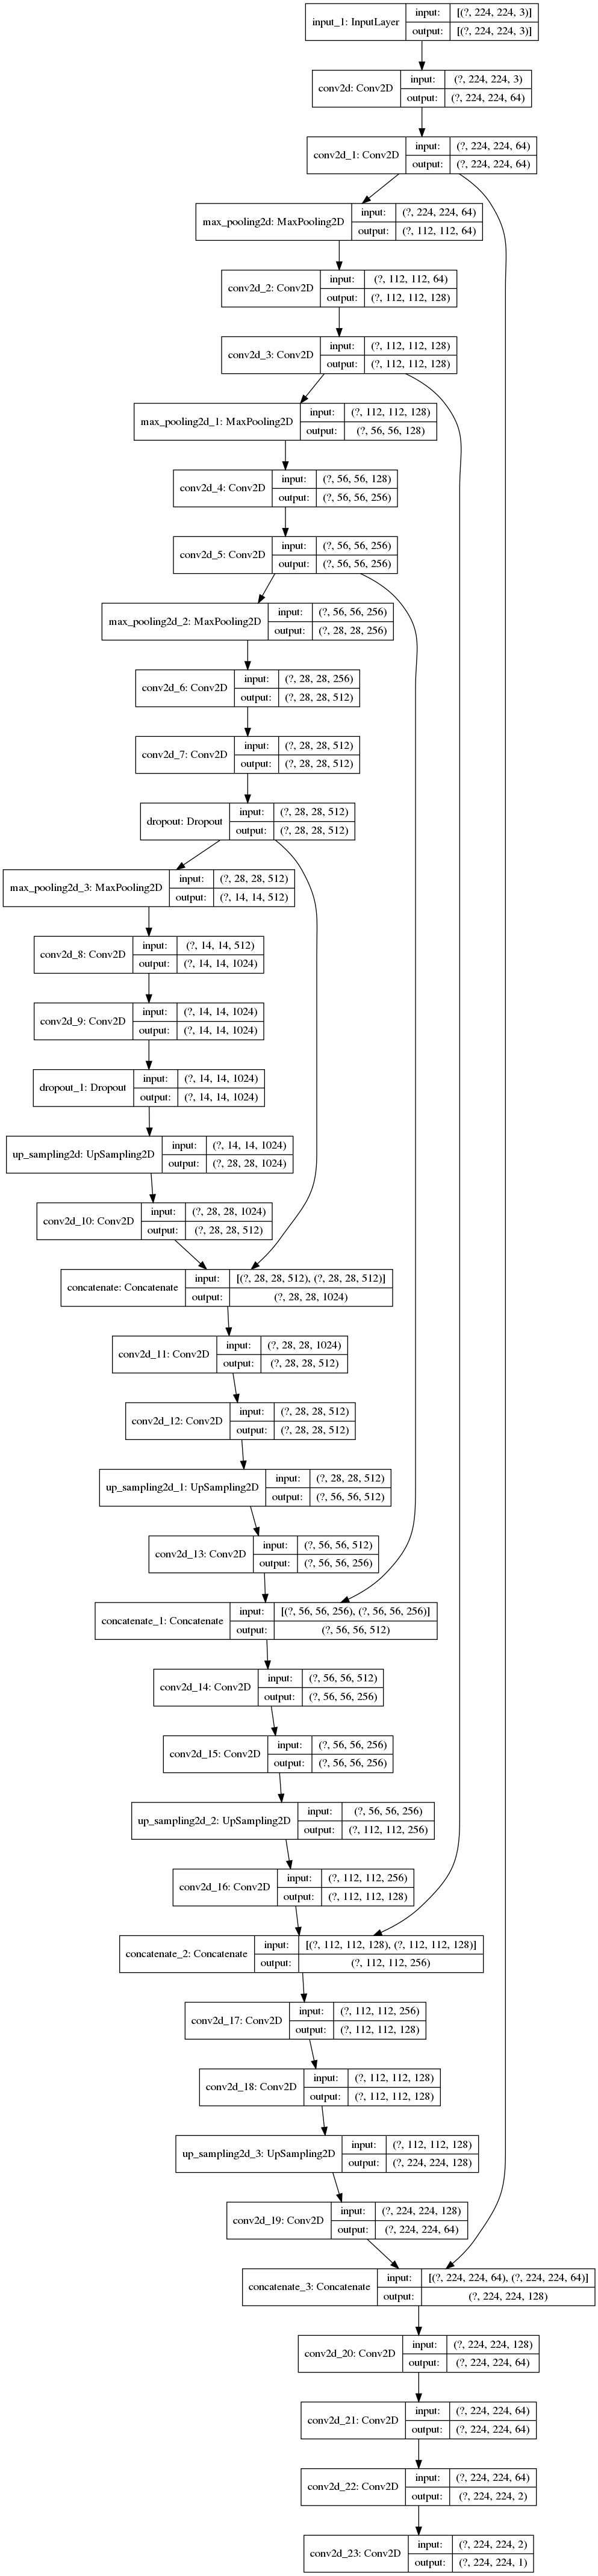

In [13]:
tf.keras.utils.plot_model(unet, to_file = "U-Net.png", show_shapes = True)

In [14]:
unet.fit_generator(
    generator       = train_generator,
    validation_data = test_generator,
    steps_per_epoch = len(train_generator),
    epochs          = 100
 )

unet_path = dir_path + "/seg_model_unet.h5"
unet.save(unet_path) #학습한 모델을 저장하자.

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
11/11 [==============================] - 5s 498ms/step - loss: 0.6929 - val_loss: 0.6926
Epoch 2/100
11/11 [==============================] - 6s 506ms/step - loss: 0.6925 - val_loss: 0.6919
Epoch 3/100
11/11 [==============================] - 6s 512ms/step - loss: 0.6891 - val_loss: 0.6780
Epoch 4/100
11/11 [==============================] - 6s 517ms/step - loss: 0.6265 - val_loss: 0.3545
Epoch 5/100
11/11 [==============================] - 6s 513ms/step - loss: 0.2381 - val_loss: 0.2623
Epoch 6/100
11/11 [==============================] - 6s 512ms/step - loss: 0.1089 - val_loss: 0.1398
Epoch 7/100
11/11 [==============================] - 6s 514ms/step - loss: 0.0481 - val_loss: 0.1203
Epoch 8/100
11/11 [==============================] - 6s 515ms/step - loss: 0.0406 - val_loss: 0.0345
Epoch 9/100
11/11 [==============================] - 6s 515ms/step - loss: 0.0339 - val_loss: 0.0342
Epoch 10/100
11

### 3. 시맨틱 세그멘테이션 모델 시각화

* 이번에는 학습한 모델의 결과를 눈으로 확인해볼 차례이다.
* 테스트 셋은 이미지를 제공하지만 정답 데이터를 제공하지 않으니 눈으로 확인할 수 있도록 모델이 추론(inference)한 결과를 우리의 눈으로 볼 수 있는 세그멘테이션 이미지로 만들자.
* 이때 입력 이미지와 라벨을 한번에 볼 수 있도록 모델의 출력값을 입력 이미지 위에 겹쳐서 보이기, 즉 오버레이(overray) 해야한다.
* PIL 패키지를 사용한다면 Image.blend를 활용할 수 있다.

In [15]:
# 참고 : 이전 스텝에서 저장된 모델은 이후 아래와 같이 로드해서 활용할 수 있다.
# model = tf.keras.models.load_model(model_path)

In [10]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data       = {"image" : origin_img}
    processed  = preproc(**data)
    output     = model(np.expand_dims(processed["image"] / 255, axis = 0))
    output     = (output[0].numpy() > 0.5).astype(np.uint8).squeeze(-1) * 255 # 0.5라는 threshold를 변경하면 도로인식 결과범위가 달라진다.
    output     = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert("RGBA")
    output     = output.resize((origin_img.shape[1], origin_img.shape[0])).convert("RGBA")
    output     = Image.blend(background, output, alpha = 0.5)
    output.show()
    return output

* 세그멘테이션이 성능을 정량적으로 측정하기 위한 방법으로 IoU(Intersection over Union)를 계산한다.
* IoU를 계산하는 방법은 지난 시간에 배웠으니 해당 내용을 활용하여 구현해보자. (블로그에 정리한 글이 있다.)
* IoU를 계산하려면 모델이 도로 영역이라고 판단한 부분이 1로, 나머지 부분이 0으로 표시된 행렬, 그리고 라벨 데이터에서 도로 영역이 1, 나머지 부분이 0으로 표시된 행렬이 필요하다.
* 각각을 prediction, target이라고 불렀을 때 이를 계산하는 함수를 구현한다.
* 위에 구현했던 get_output을 좀더 확장해서 output, prediction, target을 함께 리턴하도록 구현해보자.

In [11]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union        = np.logical_or(target,  prediction)
    iou_score    = float(np.sum(intersection)) / float(np.sum(union))
    print("IoU : %f" % iou_score )
    return iou_score

In [12]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data       = {"image" : origin_img}
    processed  = preproc(**data)
    output     = model(np.expand_dims(processed["image"] / 255, axis = 0))
    output     = (output[0].numpy() >= 0.5).astype(np.uint8).squeeze(-1) * 255 # 0.5라는 threshold를 변경하면 도로인식 결과범위가 달라진다.
    prediction = output / 255                                                  # 도로로 판단한 영역
    
    output     = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert("RGBA")
    output     = output.resize((origin_img.shape[1], origin_img.shape[0])).convert("RGBA")
    output     = Image.blend(background, output, alpha = 0.5)
    output.show()                                                              # 도로로 판단한 영역을 시각화하기
     
    if label_path:   
        label_img       = imread(label_path)
        label_data      = {"image" : label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target          = (label_processed == 7).astype(np.uint8) * 1          # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    
    else:
        return output, prediction, _

In [19]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해보자.
# i값을 바꾸면 테스트용 파일이 달라진다. 
i = 1

output, prediction, target = get_output(
    unet, 
    test_preproc,
    image_path  = dir_path + f"/image_2/00{str(i).zfill(4)}_10.png",
    output_path = dir_path + f"./result_{str(i).zfill(3)}.png",
    label_path  = dir_path + f"/semantic/00{str(i).zfill(4)}_10.png"
 )

calculate_iou_score(target, prediction)

IoU : 0.819973


0.8199725148877691

### 4. 프로젝트 : 개선된 U-Net 모델 만들기

* U-Net을 통한 시맨틱 세그멘테이션 결과가 만족스러운가?
* 어느정도 동작하는 것 같지만 좀 더 개선할 여지도 보일 것이다.
* 2018년에 U-Net++라는 논문이 나왔다.
* 이 논문은 기존에 아주 단순하면서도 세그멘테이션에서 효과를 발휘했던 U-Net의 네트워크 구조에 DenseNet의 아이디어를 가미하여 성능을 개선한 모델이다.
* 그래서 모델의 구조 자체는 직관적으로 이해가 가능한 수준이다.
* 위에서 본 U-Net의 모델 코드를 조금만 수정 확장하면 충분히 구현할 수 있다.
* 그래서 오늘의 과제는 바로 U-Net++ 모델을 스스로의 힘으로 직접 구현해 보고, U-Net을 활용했던 도로 세그멘테이션 태스크에 적용하여 U-Net을 썼을 때보다 성능이 향상되었음을 확인해 보는 것이다.
* 정성적으로는 두 모델의 세그멘테이션 결과를 시각화해서 비교해 볼 수 있을 것이고, 정량적으로는 동일 이미지에 대한 IoU값을 비교해 보면 될 것이다.

![python image](Pictures/GC-5-P-UNPP.max-800x600.png)

#### 4_1. Step 1. KITTI 데이터셋 수집과 구축

* 다운받아 둔 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축한다.
* 이때 주의할 점이 있다.
* U-Net++는 내부적인 메모리 사용량이 U-Net보다 꽤 많아진다.
* 8GB의 GPU 메모리를 가진 모델의 경우 학습데이터의 배치 사이즈를 16 -> 4 로 줄여서 설정하시기를 권한다.

In [20]:
# 위에서 이미지를 적용했다.

#### 4_2. Step 2. U-Net++ 모델의 구현

* U-Net의 모델 구조와 소스코드를 면밀히 비교해 보다 보면, U-Net++를 어떻게 구현할 수 있을지에 대한 방안을 떠올릴 수 있을 것이다.
* 이 과정을 통해 U-Net 자체에 대한 이해도도 증진될 것이다.
* 그 외 적절히 U-Net의 백본구조, 기타 파라미터 변경 등을 통해 추가적인 성능향상이 가능할수도 있다.

In [13]:
def build_unet_plus_model(input_shape = (224, 224, 3)):
    inputs = Input(input_shape)
    
    # Contracting Path
    conv1 = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(inputs)
    conv1 = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv1)
    pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool1)
    conv2 = Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv2)
    pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool2)
    conv3 = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv3)
    pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool3)
    conv4 = Conv2D(512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv4)
    pool4 = MaxPooling2D(pool_size = (2, 2))(conv4)
    
    conv5  = Conv2D(1024, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool4)  
    batch5 = BatchNormalization()(conv5)
    
    
    # Re-designed skip pathways
    # conv1_1
    up_conv2        = Conv2D(64, 2, activation = "relu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2, 2))(conv2))
    skip_crop_conv1 = tf.image.resize(conv1, (up_conv2.shape[1], up_conv2.shape[2]))
    merge1_1        = concatenate([skip_crop_conv1, up_conv2])
    conv1_1         = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge1_1)
    conv1_1         = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv1_1)
    
    # conv2_1
    up_conv3        = Conv2D(128, 2, activation = "relu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2, 2))(conv3))
    skip_crop_conv2 = tf.image.resize(conv2, (up_conv3.shape[1], up_conv3.shape[2]))
    merge2_1        = concatenate([skip_crop_conv2 , up_conv3])
    conv2_1         = Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge2_1)
    conv2_1         = Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv2_1)
    
    # conv3_1
    up_conv4        = Conv2D(256, 2, activation = "relu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2, 2))(conv4))
    skip_crop_conv3 = tf.image.resize(conv3, (up_conv4.shape[1], up_conv4.shape[2]))
    merge3_1        = concatenate([skip_crop_conv3, up_conv4])
    conv3_1         = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge3_1)
    conv3_1         = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv3_1)
    
    # conv1_2
    up_conv2_1        = Conv2D(64, 2, activation = "relu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2, 2))(conv2_1))
    skip_crop_conv1   = tf.image.resize(conv1,   (up_conv2_1.shape[1], up_conv2_1.shape[2]))
    skip_crop_conv1_1 = tf.image.resize(conv1_1, (up_conv2_1.shape[1], up_conv2_1.shape[2]))
    merge1_2          = concatenate([skip_crop_conv1, skip_crop_conv1_1, up_conv2_1])
    conv1_2           = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge1_2)
    conv1_2           = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv1_2)
    
    # conv2_2
    up_conv3_1        = Conv2D(256, 2, activation = "relu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2, 2))(conv3_1))
    skip_crop_conv2   = tf.image.resize(conv2,   (up_conv3_1.shape[1], up_conv3_1.shape[2]))
    skip_crop_conv2_1 = tf.image.resize(conv2_1, (up_conv3_1.shape[1], up_conv3_1.shape[2]))
    merge2_2          = concatenate([skip_crop_conv2, skip_crop_conv2_1, up_conv3_1])
    conv2_2           = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge2_2)
    conv2_2           = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv2_2)

    # conv1_3
    up_conv2_2        = Conv2D(64, 2, activation = "relu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2, 2))(conv2_2))
    skip_crop_conv1   = tf.image.resize(conv1,   (up_conv2_2.shape[1], up_conv2_2.shape[2]))
    skip_crop_conv1_1 = tf.image.resize(conv1_1, (up_conv2_2.shape[1], up_conv2_2.shape[2]))
    skip_crop_conv1_2 = tf.image.resize(conv1_2, (up_conv2_2.shape[1], up_conv2_2.shape[2]))
    merge1_3          = concatenate([skip_crop_conv1, skip_crop_conv1_1, skip_crop_conv1_2, up_conv2_2])
    conv1_3           = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge1_3)
    conv1_3           = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv1_3)
    
    
    # Expansive path
    up1    = Conv2D(512, 2, activation = "relu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2, 2))(batch5)) 
    merge1 = concatenate([conv4, up1])
    conv6  = Conv2D(512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge1)
    conv6  = Conv2D(512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv6)

    up2          = Conv2D(256, 2, activation = "relu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2, 2))(conv6))
    crop_conv3   = tf.image.resize(conv3,   (up2.shape[1], up2.shape[2]))
    crop_conv3_1 = tf.image.resize(conv3_1, (up2.shape[1], up2.shape[2]))
    merge2       = concatenate([crop_conv3, crop_conv3_1, up2])
    conv7        = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge2)
    conv7        = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv7)

    up3          = Conv2D(128, 2, activation = "relu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2, 2))(conv7))
    crop_conv2   = tf.image.resize(conv2,   (up3.shape[1], up3.shape[2]))
    crop_conv2_1 = tf.image.resize(conv2_1, (up3.shape[1], up3.shape[2]))
    crop_conv2_2 = tf.image.resize(conv2_2, (up3.shape[1], up3.shape[2]))
    merge3       = concatenate([crop_conv2, crop_conv2_1, crop_conv2_2, up3])
    conv8        = Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge3)
    conv8        = Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv8)

    up4          = Conv2D(64, 2, activation = "relu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2, 2))(conv8))
    crop_conv1   = tf.image.resize(conv1,   (up4.shape[1], up4.shape[2]))
    crop_conv1_1 = tf.image.resize(conv1_1, (up4.shape[1], up4.shape[2]))
    crop_conv1_2 = tf.image.resize(conv1_2, (up4.shape[1], up4.shape[2]))
    crop_conv1_3 = tf.image.resize(conv1_3, (up4.shape[1], up4.shape[2]))
    merge4       = concatenate([crop_conv1, crop_conv1_1, crop_conv1_2, crop_conv1_3, up4])
    conv9        = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge4)
    conv9        = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv9)
    conv9        = Conv2D(2,  3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv9)
    
    conv10 = Conv2D(1, 1, activation = "sigmoid")(conv9)
    conv10 = tf.image.resize(conv10, (input_shape[0], input_shape[1]))

    model = Model(inputs = inputs, outputs = conv10)
    
    return model

In [14]:
unet_plus = build_unet_plus_model()
unet_plus.compile(optimizer = Adam(lr = 1e-4), loss = "binary_crossentropy")

In [15]:
unet_plus.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

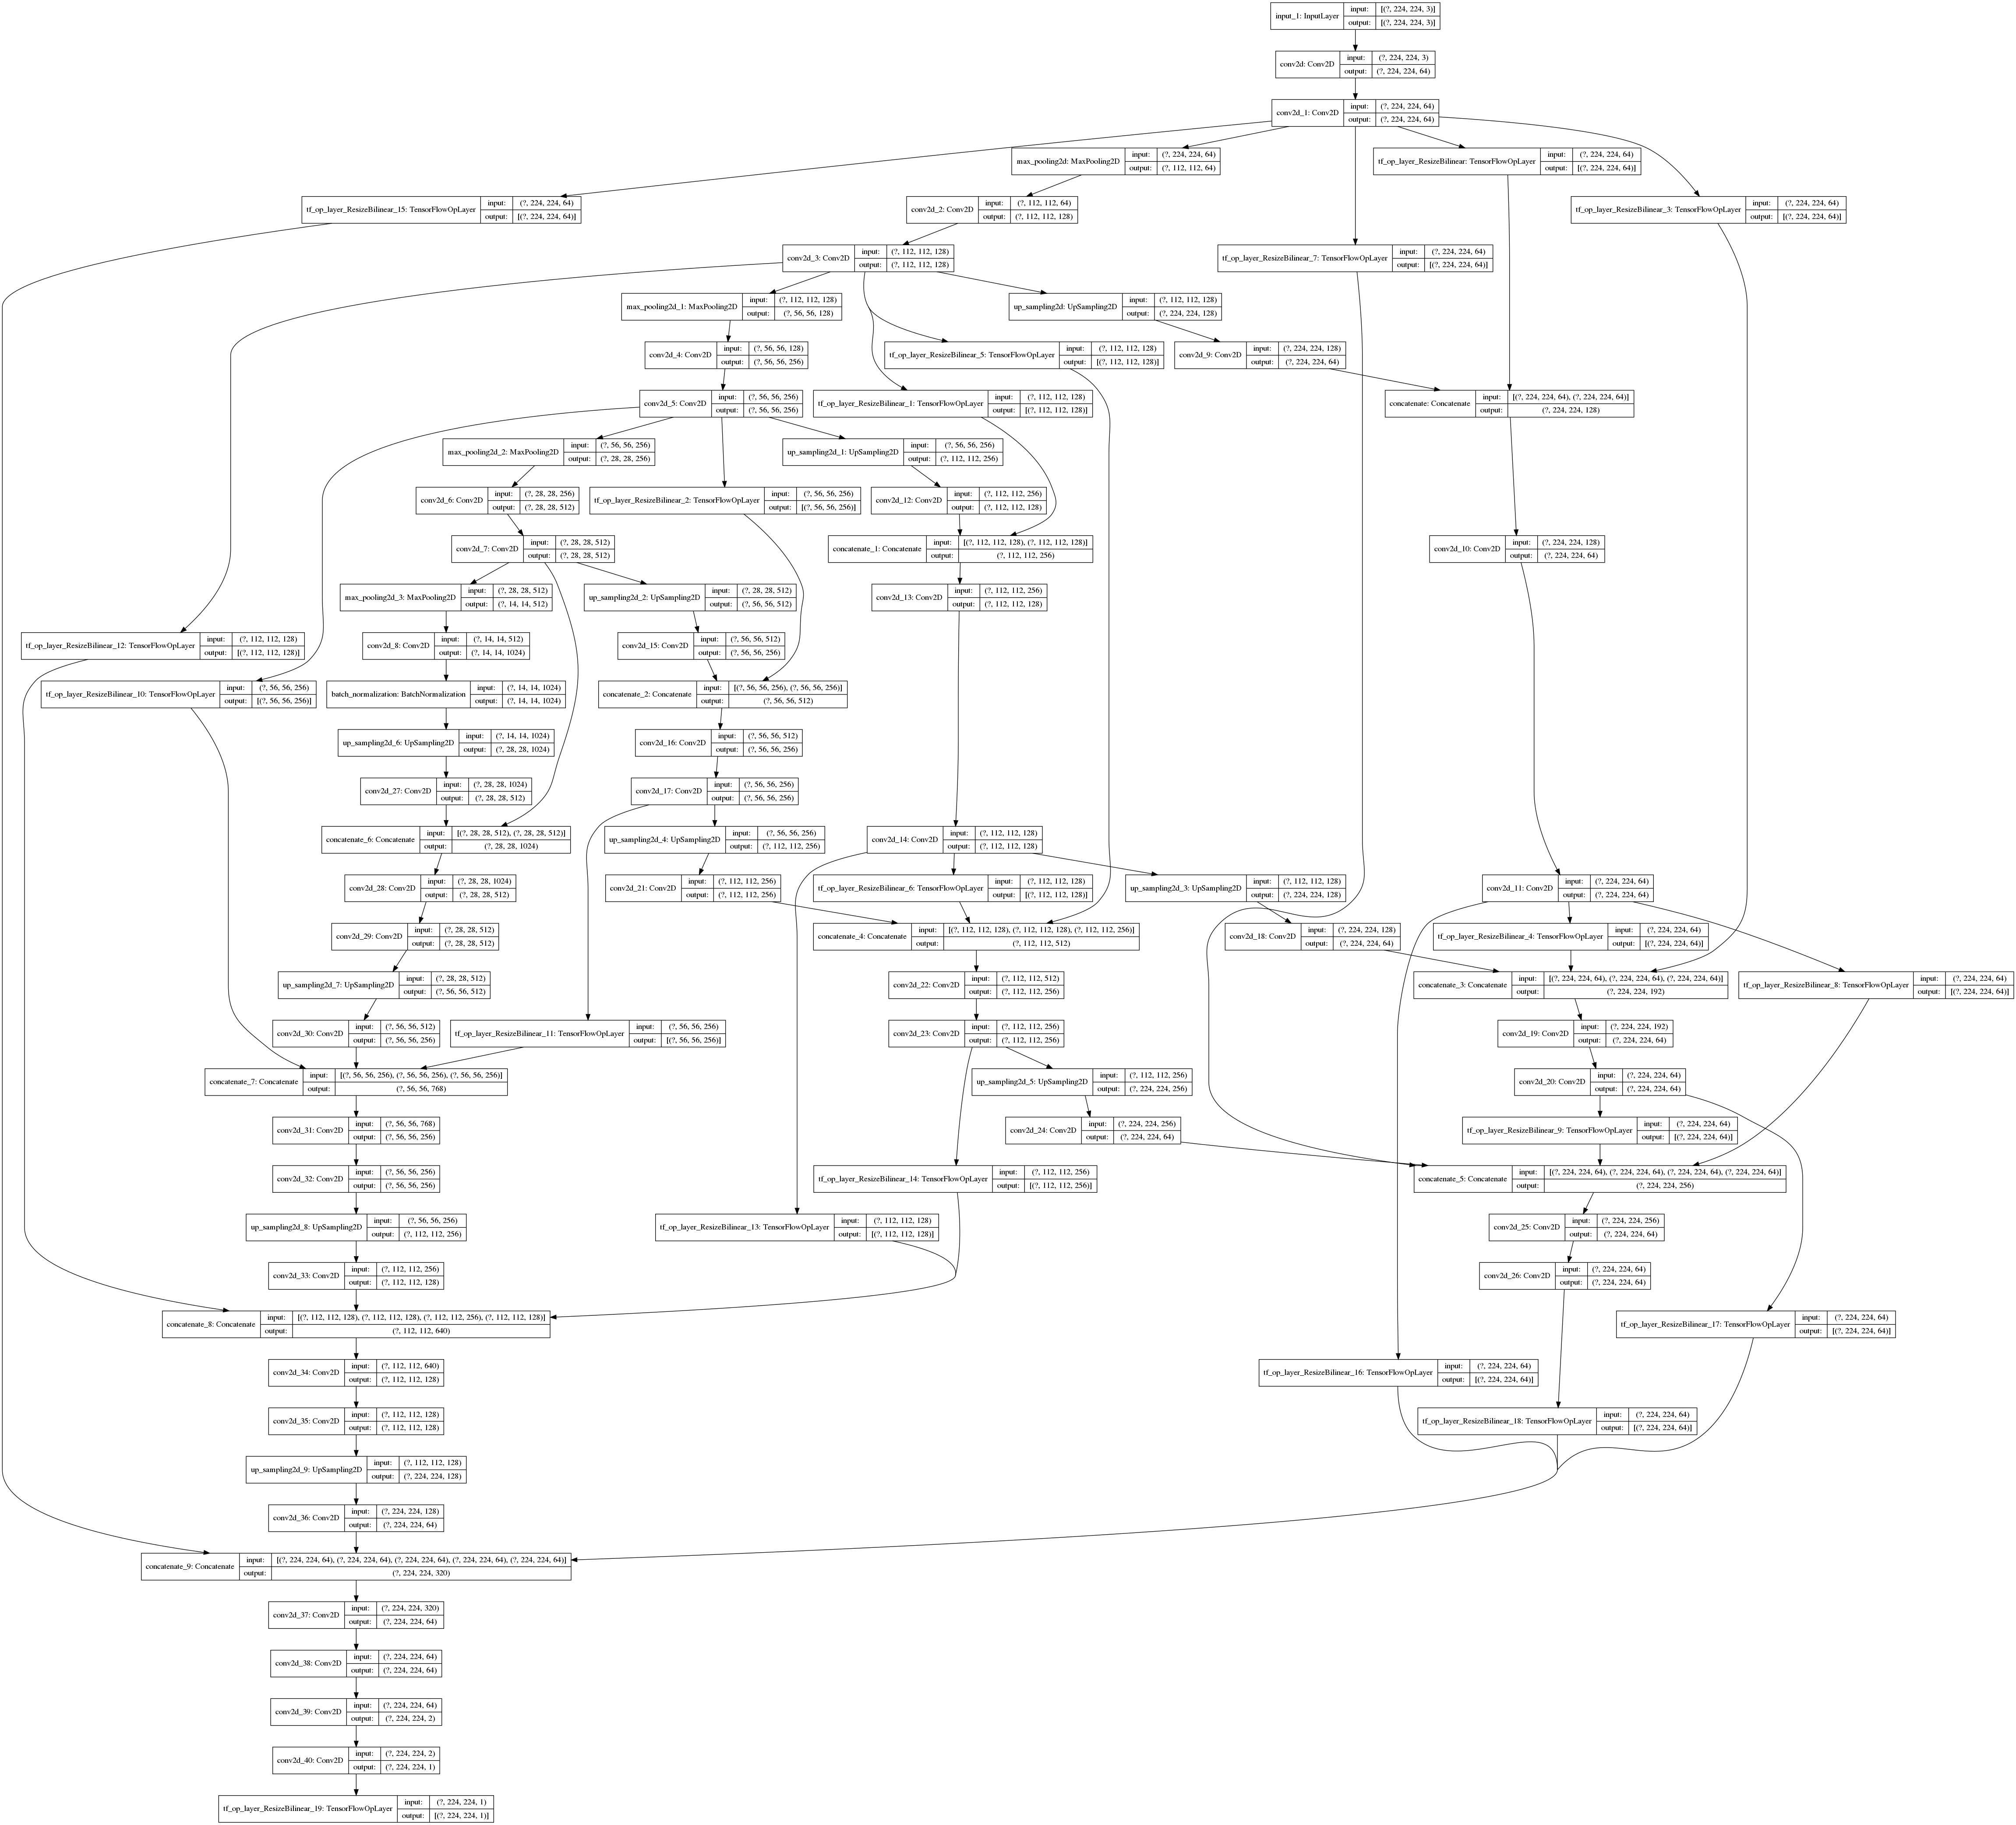

In [16]:
tf.keras.utils.plot_model(unet_plus, to_file = "U-Net++.png", show_shapes = True)

* 메모리부족으로 인한 오류가 떠서 노드에서 권장하는 것과 같이 배치사이즈를 16 -> 4로 줄였다.

In [17]:
class KittiGenerator(tf.keras.utils.Sequence):
    """
    KittiGenerator는 tf.keras.utils.Sequence를 상속받는다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용한다.
    """
    def __init__(self, 
                 dir_path,
                 batch_size   = 4,
                 img_size     = (224, 224, 3),
                 output_size  = (224, 224),
                 is_train     = True,
                 augmentation = None):
        """
        dir_path     : dataset의 directory path이다.
        batch_size   : batch_size이다.
        img_size     : preprocess에 사용할 입력이미지의 크기이다.
        output_size  : ground_truth를 만들어주기 위한 크기이다.
        is_train     : 이 Generator가 학습용인지 테스트용인지 구분한다.
        augmentation : 적용하길 원하는 augmentation 함수를 인자로 받는다.
        """
        self.dir_path     = dir_path
        self.batch_size   = batch_size
        self.is_train     = is_train
        self.dir_path     = dir_path
        self.augmentation = augmentation
        self.img_size     = img_size
        self.output_size  = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인한다.
        self.data = self.load_dataset()
    
    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수이다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야한다.
        input_images = glob(os.path.join(self.dir_path, "image_2",  "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        
        data = [_ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환한다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만든다.
        # 입력은 resize 및 augmentation이 적용된 input image이고 
        # 출력은 semantic label이다.
        batch_data = self.data[
            index * self.batch_size:
            (index + 1) * self.batch_size
        ]
        inputs  = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input                      = imread(input_img_path)
            _output                     = imread(output_path)
            _output                     = (_output == 7).astype(np.uint8) * 1
            
            data = {
                "image": _input,
                "mask": _output
            }
            
            augmented  = self.augmentation(**data)
            inputs[i]  = augmented["image"] / 255
            outputs[i] = augmented["mask"]
            
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수이다.
        # 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
        return self.indexes

In [18]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train = False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation = augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation = test_preproc,
    is_train     = False
)

In [19]:
unet_plus.fit_generator(
    generator       = train_generator,
    validation_data = test_generator,
    steps_per_epoch = len(train_generator),
    epochs          = 100
 )

unet_plus_path = dir_path + "/seg_model_unet++.h5"
unet_plus.save(unet_plus_path) #학습한 모델을 저장하자.

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
43/43 [==============================] - 20s 473ms/step - loss: 0.6863 - val_loss: 0.6779
Epoch 2/100
43/43 [==============================] - 21s 481ms/step - loss: 0.1144 - val_loss: 0.1529
Epoch 3/100
43/43 [==============================] - 21s 484ms/step - loss: 0.0843 - val_loss: 0.1268
Epoch 4/100
43/43 [==============================] - 21s 488ms/step - loss: 0.0858 - val_loss: 0.0746
Epoch 5/100
43/43 [==============================] - 21s 486ms/step - loss: 0.0689 - val_loss: 0.0761
Epoch 6/100
43/43 [==============================] - 21s 486ms/step - loss: 0.0648 - val_loss: 0.1002
Epoch 7/100
43/43 [==============================] - 21s 488ms/step - loss: 0.0654 - val_loss: 0.1194
Epoch 8/100
43/43 [==============================] - 21s 491ms/step - loss: 0.1047 - val_loss: 0.1003
Epoch 9/100
43/43 [==============================] - 21s 488ms/step - loss: 0.0842 - val_loss: 0.0844
Epoch 

Epoch 76/100
43/43 [==============================] - 21s 491ms/step - loss: 0.0396 - val_loss: 0.0383
Epoch 77/100
43/43 [==============================] - 21s 492ms/step - loss: 0.0517 - val_loss: 0.1375
Epoch 78/100
43/43 [==============================] - 21s 490ms/step - loss: 0.0321 - val_loss: 0.0909
Epoch 79/100
43/43 [==============================] - 21s 491ms/step - loss: 0.0348 - val_loss: 0.0799
Epoch 80/100
43/43 [==============================] - 21s 490ms/step - loss: 0.0325 - val_loss: 0.0624
Epoch 81/100
43/43 [==============================] - 21s 491ms/step - loss: 0.0409 - val_loss: 0.0577
Epoch 82/100
43/43 [==============================] - 21s 491ms/step - loss: 0.0327 - val_loss: 0.0964
Epoch 83/100
43/43 [==============================] - 21s 492ms/step - loss: 0.0339 - val_loss: 0.0543
Epoch 84/100
43/43 [==============================] - 21s 492ms/step - loss: 0.0293 - val_loss: 0.0486
Epoch 85/100
43/43 [==============================] - 21s 490ms/step - lo

#### 4_3. 시맨틱 세그멘테이션 모델 시각화

In [20]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해보자.
# i값을 바꾸면 테스트용 파일이 달라진다. 
i = 1

output, prediction, target = get_output(
    unet_plus, 
    test_preproc,
    image_path  = dir_path + f"/image_2/00{str(i).zfill(4)}_10.png",
    output_path = dir_path + f"./result_{str(i).zfill(3)}.png",
    label_path  = dir_path + f"/semantic/00{str(i).zfill(4)}_10.png"
 )

calculate_iou_score(target, prediction)

IoU : 0.860807


0.8608074312254377

#### 4_4. Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

* 두 모델의 정량적, 정성적 성능을 비교해보자.
* 시각화, IoU 계산 등을 체계적으로 시도해 보면 차이를 발견하실 수 있을 것이다.

In [21]:
# 정량적으로 볼 때
# U-Net은   IoU : 0.819973
# U-Net++은 IoU : 0.860807
# 의 차이를 보였다.

# 정석적으로 볼 때
# 아래의 그림에서 위쪽이 U-Net이고, 아래가 U-Net++이다.
# 차이를 보면 반대 차선의 차를 U-Net은 도로로 인식했고, U-Net++은 차로 잘 인식했다.
# 또한 앞에 차에서도 U-Net은 일부를 도로로 인식했고, U-Net++은 차로 인식했다.
# 마지막으로 오른쪽 도로를 비교하면 U-Net은 설치된 봉들도 도로로 인식했고, U-Net++은 봉을 도로로 인식하지 않았다.

![U-Net, U-Net++ image](Pictures/img.jpg)

### 회고록

In [22]:
# 분명 세그멘테이션의 개념을 볼 때만 해도 내가 이해하고 있는 것 같았는데
# 막상 모델을 구현하고, 이미지를 전처리하는 등 과정을 하면서 아직 잘 모르는 것을 깨달았다.
# 처음 U-Net을 구현할 때 summary()로 나온 것만 가지고는 이해가 안되서
# keras에 내가 짠 모델을 도식화 해주는 코드를 이용하여 그림으로 보면서 이해했다.
# 그런데 U-Net++를 구현하니 너무 모델이 복잡해보이고, 내가 잘 한건지 모르겠었다.
# IoU 수치로 볼 때도 0.05정도의 차이를 보여서 성능이 향상이 됬다고 볼 수 있는지 의문이였는데
# 위 사진처럼 서로 비교를 해보니 성능이 확실히 향상된 것을 느낄 수 있었다.